<a href="https://colab.research.google.com/github/isdeniz/pred-to-be-checked/blob/main/max-seq-300-3-labels-pred-to-be-checked-p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install transformers==4.40.2

In [10]:
pip install simpletransformers==0.64.3

In [11]:
import transformers
>>> transformers.__version__

'4.40.2'

In [12]:
import pandas as pd
from functools import partial
import sklearn
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.multiprocessing
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.multiprocessing.set_start_method('spawn', force = True)
pd.set_option('display.max_colwidth', None)
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
torch.multiprocessing.set_sharing_strategy('file_system')
cuda_available = torch.cuda.is_available()
print("Is cuda available?", cuda_available)

Is cuda available? True


In [13]:
train = pd.read_csv('data/train_df_p.csv')
test = pd.read_csv('data/test_df_p.csv')
print('Number of issues: ', train.shape, test.shape)

Number of issues:  (171392, 2) (19044, 2)


In [14]:
train.head()

,text,labels
0,2021-01-13T19:22:34Z NONE OpenAPITools/openapi-generator req update of the spring dependencies and evaluation of all the options B is your feature request related to a problem please describe the problem is the spring dependencies are using old libraries or libraries that are not relevant anymore or are superseeded by better alternatives springfox for example could be replaced by springdoc also now it only generates maven projects there should also be an option to generate only sourcecode wihtout the project files this would be a breaking change for this generator also the integration of some plugins that do some static analyzing per pipeline run on the generated projects describe the solution you d like i want to update the templates for spring so that we can build gradle maven sources with up to date libraries describe alternatives you ve considered one could set the dependencies in a parent object and leave the generated project as is but this comes with the trouble of defining old libs in the own sourcecode additional context i would completely implement this i m also open for suggestions just give me a hint if this project would welcome this update,1
1,2017-09-06T21:07:34Z NONE SeleniumHQ/selenium somehow provide a way to stop the selenium standalone server programmatically B meta os all selenium version 3 5 3 browser all expected behavior previously there was a way to shut down selenium server using http localhost 64146 selenium server driver cmd shutdownseleniumserver actual behavior no documented way to shut down selenium standalone server steps to reproduce start selenium server note no way to stop server with an api request,3
2,2018-11-11T20:39:28Z CONTRIBUTOR bazelbuild/bazel bazel crashes on windows with compiler msys gcc B exception stack trace caused by java lang illegalstateexception bazel windows unix root jvm flag is not set use the host jvm args flag for example host jvm args dbazel windows unix root c tools msys64 at com google devtools build lib util dependencyset windowspath getunixroot dependencyset java 285 at com google devtools build lib util dependencyset windowspath translatewindowspath dependencyset java 269 at com google devtools build lib util dependencyset windowspath access 000 dependencyset java 254 at com google devtools build lib util dependencyset translatepath dependencyset java 112 at com google devtools build lib util dependencyset adddependency dependencyset java 103 at com google devtools build lib util dependencyset process dependencyset java 154 at com google devtools build lib util dependencyset read dependencyset java 121 at com google devtools build lib rules cpp cppcompileaction processdepset cppcompileaction java 1277 at com google devtools build lib rules cpp cppcompileaction discoverinputsfromdotdfiles cppcompileaction java 1249 at com google devtools build lib rules cpp cppcompileaction execute cppcompileaction java 1188 at com google devtools build lib skyframe skyframeactionexecutor executeactiontask skyframeactionexecutor java 941 at com google devtools build lib skyframe skyframeactionexecutor preparescheduleexecuteandcompleteaction skyframeactionexecutor java 872 at com google devtools build lib skyframe skyframeactionexecutor access 900 skyframeactionexecutor java 114 at com google devtools build lib skyframe skyframeactionexecutor actionrunner call skyframeactionexecutor java 731 at com google devtools build lib skyframe skyframeactionexecutor actionrunner call skyframeactionexecutor java 685 at java util concurrent futuretask run futuretask java 266 at com google devtools build lib skyframe skyframeactionexecutor executeaction skyframeactionexecutor java 426 at com google devtools build lib skyframe actionexecutionfunction checkcacheandexecuteifneeded actionexecutionfunction java 490 at com google devtools build lib skyframe actionexecutionfunction compute actionexecutionfunction java 208 at com google devtools build skyframe abstractparallelevaluator ev

In [15]:
test.head()

,text,labels
0,2015-06-04T15:59:27Z CONTRIBUTOR zaproxy/zaproxy cookie without secure flag alerts not showing with spider B the alerts of the passive scanner cookie without secure flag are not shown when the pages are visited with the spider this only happens when the site is accessed by the spider through http if it s accessed through https the alerts will be shown original issue reported on code google com by thc202 on 2012 01 09 15 38 37,0
1,2022-07-06T18:33:27Z NONE elastic/elasticsearch custom rescorer that returns a topdocs with zero scoredocs causes arrayindexoutofboundsexception within rescorephase B i have a custom rescorer that filters out documents below a certain threshold if all documents within the rescorer have a score below the threshold an empty topdocs is returned when an empty topdocs is returned rescorephase throws an arrayindexoutofboundsexception as the code directly references topdocs scoredocs 0 score without checking the size of the topdocs empty topdocs new topdocs new new totalhits 0 totalhits relation equal to new scoredocs 0 the bug appears to have been first introduced in v7 0 0 alpha1 and has been confirmed to appear on master to this day the commit responsible can be found in the upgrade to a lucene 8 snapshot https github com elastic elasticsearch commit 7ad71f906a9608e1c168358624f4b0a39b240296 commit pr issue in the linked commit you can see that the method signature for function topdocs changed which inadvertently requires the topdocs to not be empty at this stage a fix for this bug could be to check the size of the topdocs returned after running through all rescorers,1
2,2021-09-22T13:22:58Z NONE TeamNewPipe/NewPipe suggest new videos to watch B if you don t fill in the template properly your issue is liable to be closed if you feel tired lazy right now open your issue some other time we ll wait the comments between these brackets won t show up in the submitted issue as you can see in the preview checklist this checklist is compulsory the first box has been checked for you to show you how it is done x i checked but didn t find any duplicates open or closed of this issue in the repo seriously check o o x i have read the contribution guidelines given at https github com teamnewpipe newpipe blob head github contributing md x this issue contains only one feature request i will open one issue for every feature i want to request describe the feature you want i d like to see a new screen being added that suggests you videos to watch i d like to be able to select a few of my favorite channels and then want to be presented with some older videos or videos i haven t watched in some time basically a random way of re watching old videos this way there can be suggestions without the need for data collection either random videos suggestions or old videos from channels you ve watched the most based on watch history or select your favorite channels and get presented old videos you haven t seen in a while optionally also describe alternatives you ve considered example z is also a good alternative not as good as y but at least or i considered z but that didn t turn out to be a good idea because is your feature request related to a problem please describe it a clear and concise description of what the problem is maybe the developers and the community could brainstorm and come up with a better solution to your problem if they exist link to related issues and or prs for developers to keep track easier example i want to do x but there is no way to do it additional context add any other context like screenshots about the feature request here example here s a photo of my cat how will you everyone benefit from this feature this feature will make newpipe more interesting to use when you have finished watching your chronological feed sometimes you just want to continue watching some more videos in other apps this would be achieved by taking in your watch history and suggestions new content based on that newpipe obviou

In [16]:
label_encoding = {'bug': 0, 'enhancement': 1, 'out-of-scope': 2, 'to-be-checked': 3}

In [17]:
train_wo_t = train.copy(deep = True)
train_wo_t = train_wo_t[train_wo_t['labels'] != 3]
train_wo_t = train_wo_t.reset_index(drop = True)
train_wo_t.shape[0]

149535

In [18]:
train_wo_t['labels'].value_counts()

labels
2    67527
0    49864
1    32144
Name: count, dtype: int64

In [19]:
train_label_perc = train_wo_t['labels'].value_counts(normalize = True) * 100
train_label_perc

labels
2    45.157990
0    33.346039
1    21.495971
Name: proportion, dtype: float64

In [20]:
test_wo_t = test.copy(deep = True)
test_wo_t = test_wo_t[test_wo_t['labels'] != 3]
test_wo_t = test_wo_t.reset_index(drop = True)
test_wo_t.shape[0]

16615

In [21]:
test_wo_t['labels'].value_counts()

labels
2    7503
0    5540
1    3572
Name: count, dtype: int64

In [22]:
test_label_perc = test_wo_t['labels'].value_counts(normalize = True) * 100
test_label_perc

labels
2    45.157990
0    33.343364
1    21.498646
Name: proportion, dtype: float64

In [23]:
lr = 3e-5
drp = 0
epochs = 4
batch_t = 100
batch_e = 100
# max_seq = 200
max_seq = 300
name = 'roberta'
ver = 'roberta-base'
output_name = 'outputs/' + name

def create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq):
    model_args = ClassificationArgs()
    model_name = name
    model_version = ver
    model_args.learning_rate = lr
    model_args.num_train_epochs = epochs
    model_args.eval_batch_size = batch_t
    model_args.train_batch_size = batch_e
    model_args.max_seq_length = max_seq
    # model_args.n_gpu = 2
    model_args.n_gpu = 1
    model_args.output_dir = output_name +'/'
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.preprocess_inputs = True
    model_args.save_steps = -1
    model_args.save_model_every_epoch = False

    model = ClassificationModel(model_name, model_version, args = model_args,
                                num_labels = 3,
                                use_cuda = cuda_available)

    return model

In [24]:
def calc(p1, p2, func, **kwargs):
    return func(p1, p2, **kwargs)

metrics_recom = {
    "accuracy": partial(calc,func=sklearn.metrics.accuracy_score) ,
    "p_micro": partial(calc,func=sklearn.metrics.precision_score,average='micro'),
    "p_macro": partial(calc,func=sklearn.metrics.precision_score,average='macro'),
    "p_w": partial(calc,func=sklearn.metrics.precision_score,average='weighted'),
    "r_micro": partial(calc,func=sklearn.metrics.recall_score,average='micro'),
    "r_macro": partial(calc,func=sklearn.metrics.recall_score,average='macro'),
    "r_w": partial(calc,func=sklearn.metrics.recall_score,average='weighted'),
    "f_micro": partial(calc,func=sklearn.metrics.f1_score,average='micro'),
    "f_macro": partial(calc,func=sklearn.metrics.f1_score,average='macro'),
    "f_w": partial(calc,func=sklearn.metrics.f1_score,average='weighted'),
    "classificationReport": partial(calc,func=sklearn.metrics.classification_report, output_dict = True)
}

In [25]:
model = create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq)
start = datetime.datetime.now()
print('-'*5,  name, ', start time:',
datetime.datetime.strftime(datetime.datetime.today(), '%d/%m/%Y-%H:%M'), '-'*5)
model.train_model(train_df = train_wo_t, **metrics_recom)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

----- roberta , start time: 26/05/2024-18:22 -----


  0%|          | 0/149535 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1496 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1496 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1496 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1496 [00:00<?, ?it/s]

(5984, 0.3761469062148807)

In [26]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results, model_outputs, wrong_pred = model.eval_model(test_wo_t, verbose=True, **metrics_recom)
results

----- roberta , duration is: 0h:29m:29s ----- 




  0%|          | 0/16615 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/167 [00:00<?, ?it/s]

{'mcc': 0.7851130281464018,
 'accuracy': 0.8625940415287391,
 'p_micro': 0.8625940415287391,
 'p_macro': 0.8543623229349068,
 'p_w': 0.8627911489639766,
 'r_micro': 0.8625940415287391,
 'r_macro': 0.855850574695631,
 'r_w': 0.8625940415287391,
 'f_micro': 0.8625940415287391,
 'f_macro': 0.8550903533035997,
 'f_w': 0.8626750182440261,
 'classificationReport': {'0.0': {'precision': 0.8572450805008944,
   'recall': 0.8649819494584837,
   'f1-score': 0.8610961365678346,
   'support': 5540},
  '1.0': {'precision': 0.8172969966629589,
   'recall': 0.8227883538633819,
   'f1-score': 0.8200334821428571,
   'support': 3572},
  '2.0': {'precision': 0.8885448916408669,
   'recall': 0.8797814207650273,
   'f1-score': 0.8841414412001073,
   'support': 7503},
  'accuracy': 0.8625940415287391,
  'macro avg': {'precision': 0.8543623229349068,
   'recall': 0.855850574695631,
   'f1-score': 0.8550903533035997,
   'support': 16615},
  'weighted avg': {'precision': 0.8627911489639766,
   'recall': 0.86259

In [27]:
model_outputs.shape[0]

16615

In [28]:
model_outputs_df = pd.DataFrame(model_outputs, columns = ['bug', 'enhancement', 'out-of-scope'])
model_outputs_df.head()

,bug,enhancement,out-of-scope
0,3.468750,-0.372314,-2.595703
1,4.386719,-2.392578,-1.327148
2,-3.955078,2.312500,0.882812
3,-0.910156,-3.382812,4.527344
4,-3.316406,1.509766,1.434570


In [29]:
def get_prediction(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['enhancement']:
    return 1
  elif max_value == row['out-of-scope']:
    return 2
  elif max_value == row['to-be-checked']:
    return 3

In [30]:
model_outputs_df['prediction'] = model_outputs_df.apply(get_prediction, axis = 1)
model_outputs_df.head()

,bug,enhancement,out-of-scope,prediction
0,3.468750,-0.372314,-2.595703,0
1,4.386719,-2.392578,-1.327148,0
2,-3.955078,2.312500,0.882812,1
3,-0.910156,-3.382812,4.527344,2
4,-3.316406,1.509766,1.434570,1


In [31]:
test_wo_t.shape[0]

16615

In [32]:
model_outputs_df['actual'] = test_wo_t['labels']
model_outputs_df.head()

,bug,enhancement,out-of-scope,prediction,actual
0,3.468750,-0.372314,-2.595703,0,0
1,4.386719,-2.392578,-1.327148,0,1
2,-3.955078,2.312500,0.882812,1,1
3,-0.910156,-3.382812,4.527344,2,2
4,-3.316406,1.509766,1.434570,1,2


In [33]:
label_names = ['bug', 'enhancement', 'out-of-scope']

In [34]:
predicted_labels = model_outputs_df['prediction']
actual_labels = model_outputs_df['actual']

In [35]:
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)
print(confusion_matrix)

[[4792  265  483]
 [ 288 2939  345]
 [ 510  392 6601]]


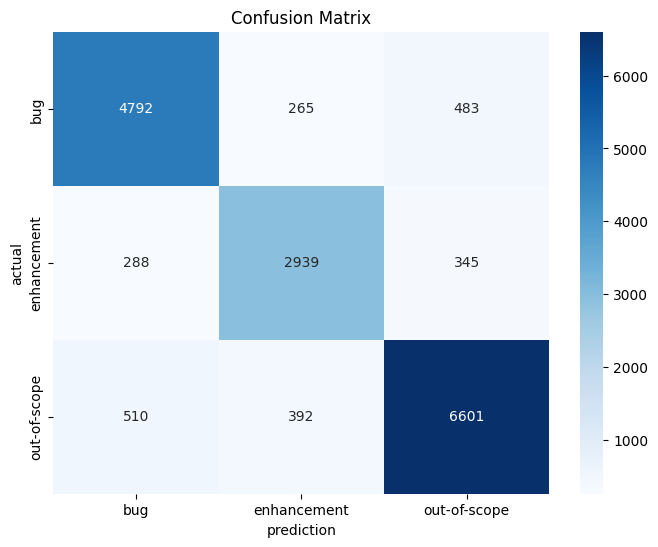

In [36]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
test_wo_t['labels'].value_counts()

labels
2    7503
0    5540
1    3572
Name: count, dtype: int64

Performance on training set

In [38]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results_train, model_outputs_train, wrong_pred_train = model.eval_model(train_wo_t, verbose=True, **metrics_recom)
results_train

----- roberta , duration is: 0h:33m:25s ----- 




  0%|          | 0/149535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1496 [00:00<?, ?it/s]

{'mcc': 0.856525980438776,
 'accuracy': 0.9082823419266393,
 'p_micro': 0.9082823419266393,
 'p_macro': 0.9041286581051873,
 'p_w': 0.9084171146512922,
 'r_micro': 0.9082823419266393,
 'r_macro': 0.9042131307400224,
 'r_w': 0.9082823419266393,
 'f_micro': 0.9082823419266393,
 'f_macro': 0.9041212552644896,
 'f_w': 0.9082990353258507,
 'classificationReport': {'0.0': {'precision': 0.8965476611287853,
   'recall': 0.9155703513556874,
   'f1-score': 0.9059591609945825,
   'support': 49864},
  '1.0': {'precision': 0.8897892521750055,
   'recall': 0.8813464410154306,
   'f1-score': 0.885547723614085,
   'support': 32144},
  '2.0': {'precision': 0.9260490610117711,
   'recall': 0.9157225998489493,
   'f1-score': 0.9208568811848014,
   'support': 67527},
  'accuracy': 0.9082823419266393,
  'macro avg': {'precision': 0.9041286581051873,
   'recall': 0.9042131307400224,
   'f1-score': 0.9041212552644896,
   'support': 149535},
  'weighted avg': {'precision': 0.9084171146512922,
   'recall': 0.9

In [39]:
model_outputs_train.shape[0]

149535

In [40]:
model_outputs_df_train = pd.DataFrame(model_outputs_train, columns = ['bug', 'enhancement', 'out-of-scope'])
model_outputs_df_train.head()

,bug,enhancement,out-of-scope
0,-1.668945,3.689453,-2.460938
1,3.925781,-0.247925,-3.296875
2,1.549805,-0.750488,-0.274170
3,0.357910,-3.404297,3.527344
4,-2.849609,-2.736328,5.316406


In [41]:
model_outputs_df_train['prediction'] = model_outputs_df_train.apply(get_prediction, axis = 1)
model_outputs_df_train.head()

,bug,enhancement,out-of-scope,prediction
0,-1.668945,3.689453,-2.460938,1
1,3.925781,-0.247925,-3.296875,0
2,1.549805,-0.750488,-0.274170,0
3,0.357910,-3.404297,3.527344,2
4,-2.849609,-2.736328,5.316406,2


In [42]:
train_wo_t.shape[0]

149535

In [43]:
model_outputs_df_train['actual'] = train_wo_t['labels']
model_outputs_df_train.head()

,bug,enhancement,out-of-scope,prediction,actual
0,-1.668945,3.689453,-2.460938,1,1
1,3.925781,-0.247925,-3.296875,0,0
2,1.549805,-0.750488,-0.274170,0,0
3,0.357910,-3.404297,3.527344,2,2
4,-2.849609,-2.736328,5.316406,2,2


In [44]:
predicted_labels_train = model_outputs_df_train['prediction']
actual_labels_train = model_outputs_df_train['actual']

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
confusion_matrix_train = confusion_matrix(actual_labels_train, predicted_labels_train)
print(confusion_matrix_train)

[[45654  1186  3024]
 [ 1900 28330  1914]
 [ 3368  2323 61836]]


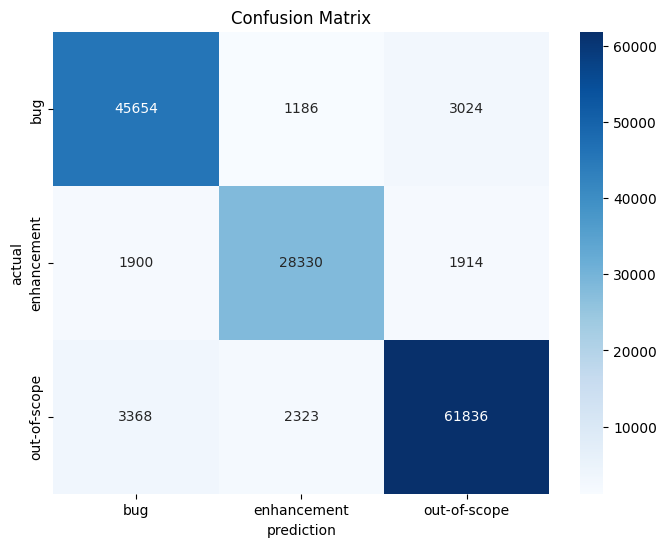

In [47]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix_train,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

In [48]:
train_wo_t['labels'].value_counts()

labels
2    67527
0    49864
1    32144
Name: count, dtype: int64

Predicting to-be-checked issues

In [49]:
train_t = train.copy(deep = True)
train_t = train_t[train_t['labels'] == 3]
train_t = train_t.reset_index(drop = True)
train_t.shape[0]

21857

In [50]:
train_t['labels'].value_counts()

labels
3    21857
Name: count, dtype: int64

In [51]:
test_t = test.copy(deep = True)
test_t = test_t[test_t['labels'] == 3]
test_t = test_t.reset_index(drop = True)
test_t.shape[0]

2429

In [52]:
test_t['labels'].value_counts()

labels
3    2429
Name: count, dtype: int64

In [53]:
to_be_checked_issues = pd.concat([train_t, test_t], ignore_index = True)

In [54]:
to_be_checked_issues.shape[0]

24286

In [55]:
to_be_checked_issues.head()

,text,labels
0,2017-09-06T21:07:34Z NONE SeleniumHQ/selenium somehow provide a way to stop the selenium standalone server programmatically B meta os all selenium version 3 5 3 browser all expected behavior previously there was a way to shut down selenium server using http localhost 64146 selenium server driver cmd shutdownseleniumserver actual behavior no documented way to shut down selenium standalone server steps to reproduce start selenium server note no way to stop server with an api request,3
1,2018-08-14T11:08:15Z NONE neo4j/neo4j neo4j 3 4 4 no more threads available B hi i upgrade the function environment to neo4j 3 4 4 and net driver 1 6 1 two weeks ago from then something like twice three times a day i get lots of this error neo4j driver v1 transientexception there are no available threads to serve this request at the moment you can retry at a later time or consider increasing max thread pool size for bolt function if i rollback the neo4j version everything works perfectly hope you can help somehow or can give me some tools how to give you more information thanks niv,3
2,2019-06-13T17:37:52Z NONE bazelbuild/bazel crosscompile on 0 26 0 for arm returns with no matching toolchains found for types bazel tools tools cpp toolchain type B attention please read and follow if this is a question about how to build test query deploy using bazel ask it on stackoverflow instead https stackoverflow com questions tagged bazel if this is a discussion starter send it to bazel discuss googlegroups com if this is a bug or feature request fill the form below as best as you can description of the problem feature request we are trying to crosscompile our targets using bazel 0 26 1 for arm everything works when we try to run using k8 however when we switch to cpu arm we get the following error warning ignoring java home because it must point to a jdk not a jre info invocation id 61c08ab3 983f 474e bb68 05e3a49158e9 info toolchainresolution selected execution platform bazel tools platforms host platform info toolchainresolution looking for toolchain of type bazel tools tools cpp toolchain type info toolchainresolution considering toolchain local config cc cc compiler armabi v7a info toolchainresolution toolchain constraint bazel tools platforms os has value bazel tools platforms android which does not match value bazel tools platforms linux from the target platform bazel tools platforms target platform info toolchainresolution rejected toolchain local config cc cc compiler armabi v7a because of target platform mismatch info toolchainresolution considering toolchain local config cc cc compiler k8 info toolchainresolution toolchain constraint bazel tools platforms cpu has value bazel tools platforms x86 64 which does not match value bazel tools platforms arm from the target platform bazel tools platforms target platform info toolchainresolution rejected toolchain local config cc cc compiler k8 because of target platform mismatch info toolchainresolution no toolchains found error while resolving toolchains for target org lzma lzma lzma no matching toolchains found for types bazel tools tools cpp toolchain type error analysis of target org lzma lzma lzma failed build aborted no matching toolchains found for types bazel tools tools cpp toolchain type bugs what s the simplest easiest way to reproduce this bug please provide a minimal example if possible setting cpu arm causes the issue to manifest what operating system are you running bazel on ubuntu 16 04 what s the output of bazel info release warning ignoring java home because it must point to a jdk not a jre info invocation id de5b36b8 0198 4894 9c66 a72299d652f1 release 0 26 0,3
3,2019-11-20T13:16:28Z CONTRIBUTOR quarkusio/quarkus grpc support B description implementing support for grpc https grpc io is likely to be a long running task this epic is to cover the minimum viable product implementation so that we can release something useful asap and then iterate on it going forwards an early t

In [56]:
pred, raw_outputs = model.predict(to_be_checked_issues['text'].tolist())

  0%|          | 0/24286 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

In [57]:
pred

array([1, 0, 0, ..., 1, 2, 1])

In [58]:
raw_outputs

array([[-1.36328125,  3.16796875, -2.3671875 ],
       [ 2.22851562, -1.63183594, -0.14538574],
       [ 3.73632812, -0.64160156, -2.71875   ],
       ...,
       [ 0.80859375,  2.24414062, -2.79101562],
       [-0.93554688, -1.24511719,  2.47460938],
       [-2.06835938,  1.19824219,  1.04199219]])

In [59]:
prediction_to_be_checked = pd.DataFrame(columns = ['text', 'prediction'])

In [60]:
prediction_to_be_checked['text'] = to_be_checked_issues['text']

In [61]:
pred_df = pd.DataFrame(pred, columns = ['prediction'])
pred_df.head()

,prediction
0,1
1,0
2,0
3,1
4,0


In [62]:
prediction_to_be_checked['prediction'] = pred_df['prediction']

In [63]:
prediction_to_be_checked.head()

,text,prediction
0,2017-09-06T21:07:34Z NONE SeleniumHQ/selenium somehow provide a way to stop the selenium standalone server programmatically B meta os all selenium version 3 5 3 browser all expected behavior previously there was a way to shut down selenium server using http localhost 64146 selenium server driver cmd shutdownseleniumserver actual behavior no documented way to shut down selenium standalone server steps to reproduce start selenium server note no way to stop server with an api request,1
1,2018-08-14T11:08:15Z NONE neo4j/neo4j neo4j 3 4 4 no more threads available B hi i upgrade the function environment to neo4j 3 4 4 and net driver 1 6 1 two weeks ago from then something like twice three times a day i get lots of this error neo4j driver v1 transientexception there are no available threads to serve this request at the moment you can retry at a later time or consider increasing max thread pool size for bolt function if i rollback the neo4j version everything works perfectly hope you can help somehow or can give me some tools how to give you more information thanks niv,0
2,2019-06-13T17:37:52Z NONE bazelbuild/bazel crosscompile on 0 26 0 for arm returns with no matching toolchains found for types bazel tools tools cpp toolchain type B attention please read and follow if this is a question about how to build test query deploy using bazel ask it on stackoverflow instead https stackoverflow com questions tagged bazel if this is a discussion starter send it to bazel discuss googlegroups com if this is a bug or feature request fill the form below as best as you can description of the problem feature request we are trying to crosscompile our targets using bazel 0 26 1 for arm everything works when we try to run using k8 however when we switch to cpu arm we get the following error warning ignoring java home because it must point to a jdk not a jre info invocation id 61c08ab3 983f 474e bb68 05e3a49158e9 info toolchainresolution selected execution platform bazel tools platforms host platform info toolchainresolution looking for toolchain of type bazel tools tools cpp toolchain type info toolchainresolution considering toolchain local config cc cc compiler armabi v7a info toolchainresolution toolchain constraint bazel tools platforms os has value bazel tools platforms android which does not match value bazel tools platforms linux from the target platform bazel tools platforms target platform info toolchainresolution rejected toolchain local config cc cc compiler armabi v7a because of target platform mismatch info toolchainresolution considering toolchain local config cc cc compiler k8 info toolchainresolution toolchain constraint bazel tools platforms cpu has value bazel tools platforms x86 64 which does not match value bazel tools platforms arm from the target platform bazel tools platforms target platform info toolchainresolution rejected toolchain local config cc cc compiler k8 because of target platform mismatch info toolchainresolution no toolchains found error while resolving toolchains for target org lzma lzma lzma no matching toolchains found for types bazel tools tools cpp toolchain type error analysis of target org lzma lzma lzma failed build aborted no matching toolchains found for types bazel tools tools cpp toolchain type bugs what s the simplest easiest way to reproduce this bug please provide a minimal example if possible setting cpu arm causes the issue to manifest what operating system are you running bazel on ubuntu 16 04 what s the output of bazel info release warning ignoring java home because it must point to a jdk not a jre info invocation id de5b36b8 0198 4894 9c66 a72299d652f1 release 0 26 0,0
3,2019-11-20T13:16:28Z CONTRIBUTOR quarkusio/quarkus grpc support B description implementing support for grpc https grpc io is likely to be a long running task this epic is to cover the minimum viable product implementation so that we can release something useful asap and then iterate on it going forwards an ear

In [64]:
prediction_to_be_checked['prediction'].value_counts()

prediction
0    10415
2     7472
1     6399
Name: count, dtype: int64

In [65]:
prediction_to_be_checked.to_csv('data/prediction_to_be_checked_p.csv')